/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


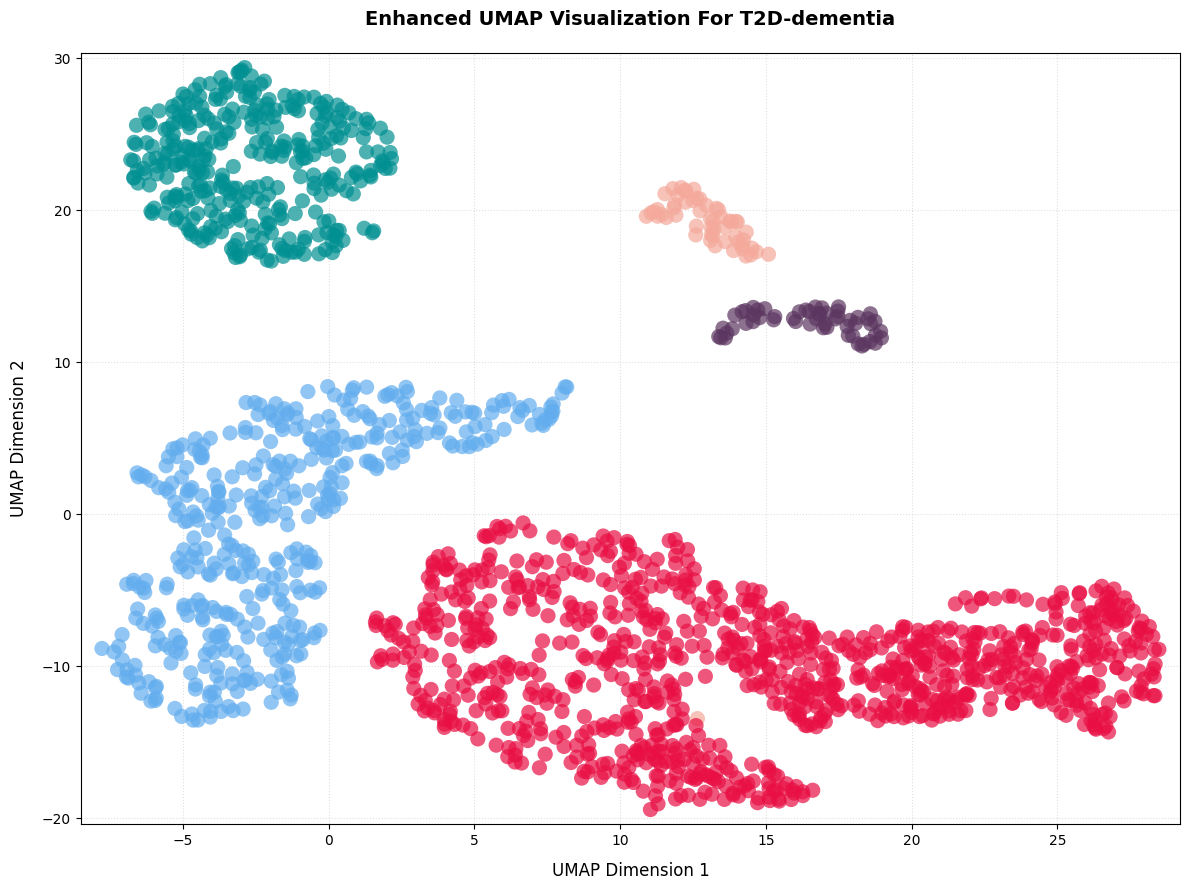

In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import numpy as np


filtered_df = pd.read_csv('/code/Figure1/Figure1c/filtered_proteins_trend_with_label.csv')
features = filtered_df.iloc[:, 2:].values  
trend_labels = filtered_df['Trend']


le = LabelEncoder()
trend_encoded = le.fit_transform(trend_labels)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



kmeans = KMeans(
    n_clusters=len(le.classes_),  
    random_state=42,
    n_init=20
)


umap_model = umap.UMAP(
    n_neighbors=25,          
    min_dist=1,            
    spread=1.5,              
    local_connectivity=2,
    n_components=2,
    metric='euclidean',
    random_state=42,
    repulsion_strength=1  
)
umap_result = umap_model.fit_transform(scaled_features, y=trend_encoded)


custom_colors = ['#F4A99B', '#019092', '#E90F44', '#5B3660', '#63ADEE']
cmap = ListedColormap(custom_colors[:len(le.classes_)])
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=le.classes_[i],
               markerfacecolor=custom_colors[i], markersize=10) 
    for i in range(len(le.classes_))
]


plt.figure(figsize=(12, 9))  
ax = plt.gca()


def get_compact_range(data, margin=0.02):
    range_val = np.ptp(data)
    return (np.min(data) - range_val*margin, 
            np.max(data) + range_val*margin)

x_min, x_max = get_compact_range(umap_result[:, 0])
y_min, y_max = get_compact_range(umap_result[:, 1])
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


scatter = ax.scatter(
    umap_result[:, 0], 
    umap_result[:, 1],
    c=trend_encoded,
    cmap=cmap,
    alpha=0.7,             
    s=120,                  
    edgecolor=None,
    linewidth=0,          
    zorder=3                
)



plt.title('Enhanced UMAP Visualization For T2D-dementia', 
          pad=20, fontsize=14, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12, labelpad=10)
plt.ylabel('UMAP Dimension 2', fontsize=12, labelpad=10)


ax.grid(True, linestyle=':', alpha=0.4, which='both', zorder=0)
ax.set_axisbelow(True)  


plt.tight_layout()
plt.savefig('/results/Figure1cenhanced_umap.pdf', dpi=600, bbox_inches='tight', transparent=False)
plt.show()




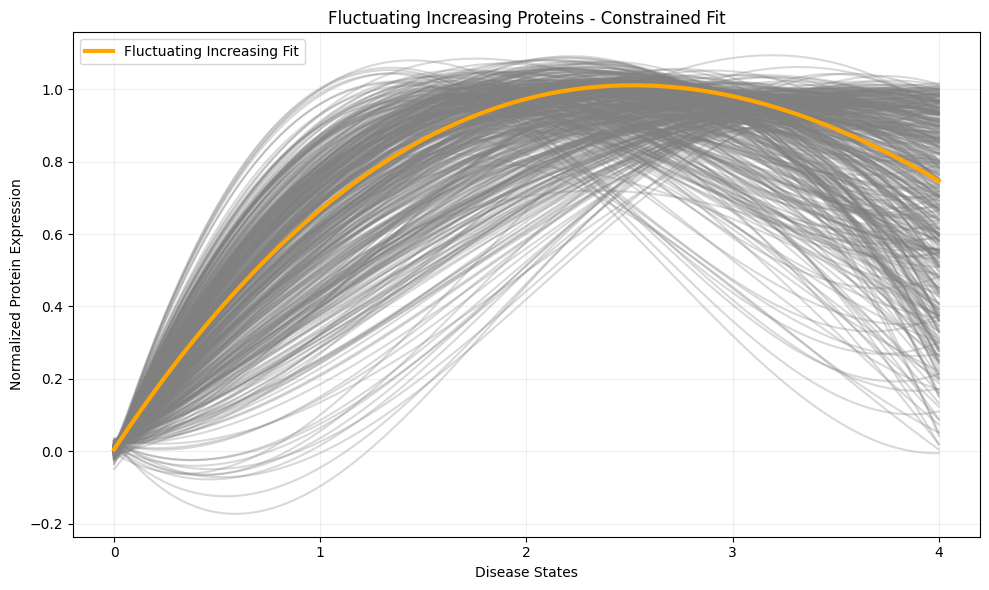

Saved: /results/protein_trend_plots_pdf/Fluctuating_Increasing_trend.pdf


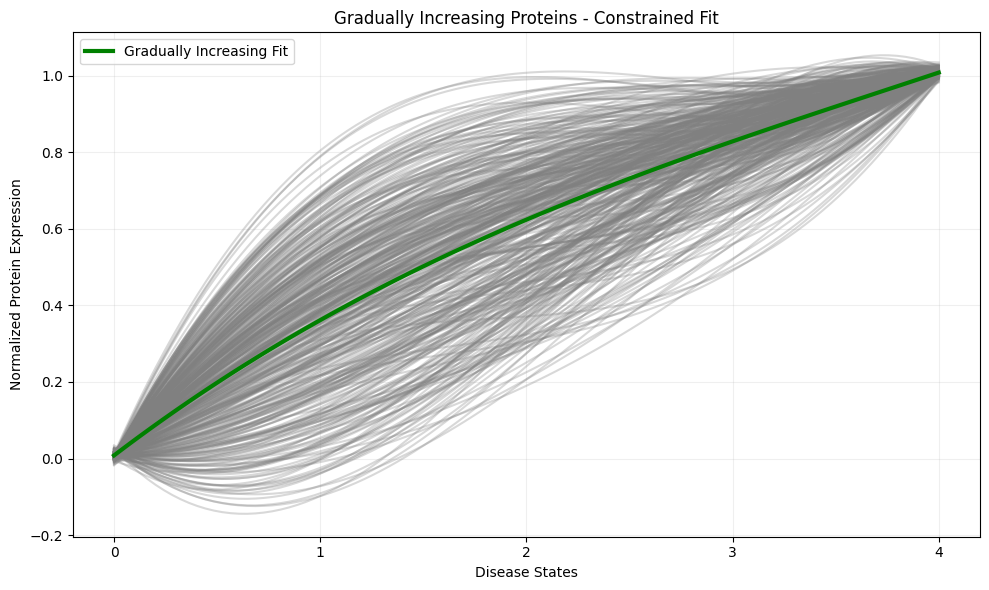

Saved: /results/protein_trend_plots_pdf/Gradually_Increasing_trend.pdf


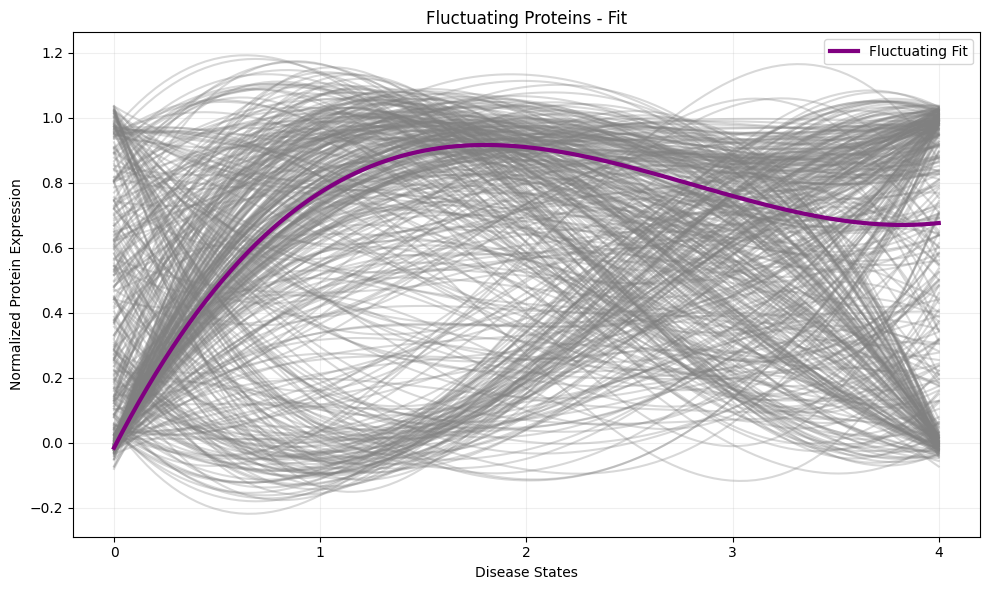

Saved: /results/protein_trend_plots_pdf/Fluctuating_trend.pdf


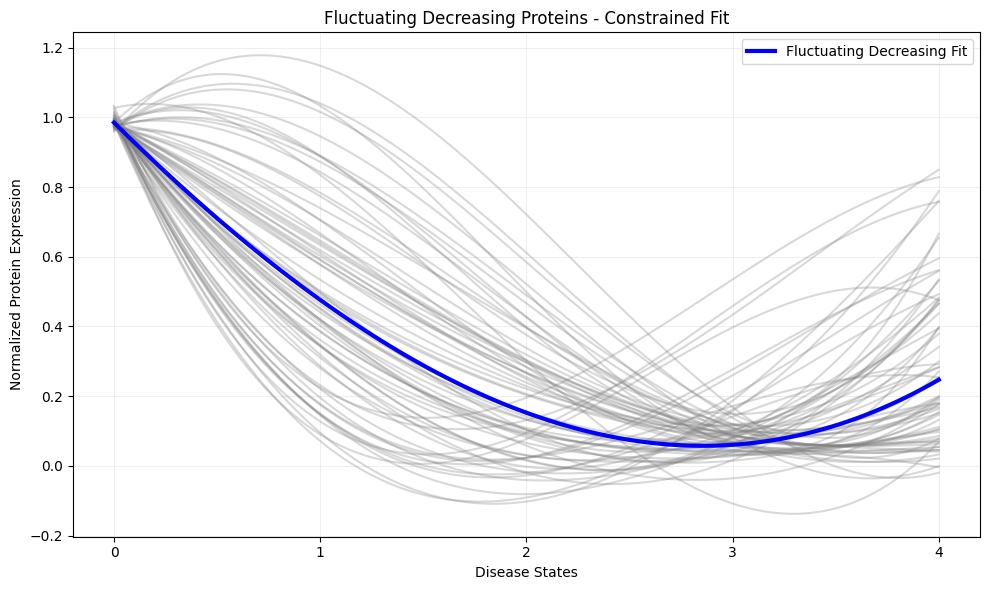

Saved: /results/protein_trend_plots_pdf/Fluctuating_Decreasing_trend.pdf


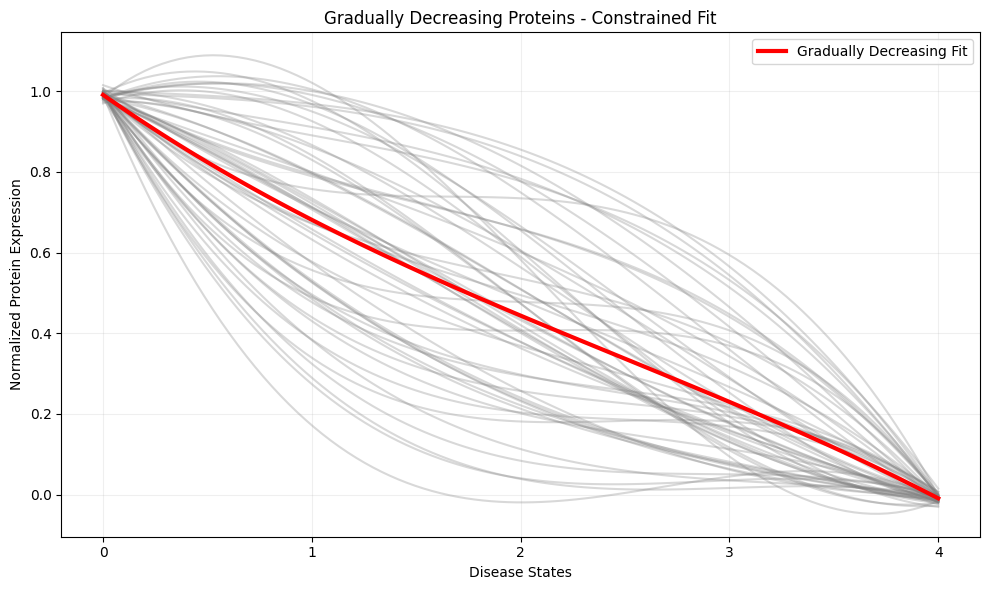

Saved: /results/protein_trend_plots_pdf/Gradually_Decreasing_trend.pdf


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
import os



output_dir = "/results/protein_trend_plots_pdf"
os.makedirs(output_dir, exist_ok=True)

def constrained_spline_fit(x, y, trend_type=None, s=0.5):
    """Constrained smoothing spline fitting"""
    spline = UnivariateSpline(x, y, s=s)
    
    
    if trend_type in ["Gradually Decreasing", "Gradually Increasing",
                     "Fluctuating Increasing", "Fluctuating Decreasing"]:
        
     
        def get_key_derivatives(params):
            spline.set_smoothing_factor(params[0])
            deriv_at_end = spline.derivative()(x[-1])  
            if trend_type in ["Fluctuating Increasing", "Fluctuating Decreasing"]:
                deriv_at_2 = spline.derivative()(2)  
                return deriv_at_2, deriv_at_end
            return deriv_at_end
        
     
        def constraint(params):
            if trend_type == "Gradually Decreasing":
                return -get_key_derivatives(params)  
            elif trend_type == "Gradually Increasing":
                return get_key_derivatives(params)   
            elif trend_type == "Fluctuating Increasing":
                deriv_at_2, deriv_at_end = get_key_derivatives(params)
                return min(deriv_at_2, -deriv_at_end) 
            else:  # "0-2 Decreasing, 3-4 Increasing"
                deriv_at_2, deriv_at_end = get_key_derivatives(params)
                return min(-deriv_at_2, deriv_at_end)  
        
        
        res = minimize(lambda s: np.sum((spline(x) - y)**2), 
                      x0=[s],
                      constraints={'type': 'ineq', 'fun': constraint},
                      bounds=[(0.01, 10)])
        spline.set_smoothing_factor(res.x[0])
    
    return spline


file_path = '/code/Figure1/Figure1c/filtered_proteins_trend_with_label-dementia.csv'
data = pd.read_csv(file_path)


all_trends = data['Trend'].unique()
constrained_trends = [
    "Gradually Decreasing", 
    "Gradually Increasing",
    "Fluctuating Increasing",
    "Fluctuating Decreasing"
]


disease_states = np.array([0, 1, 2, 3, 4])
x_smooth = np.linspace(0, 4, 100)


trend_colors = {
    "Gradually Decreasing": "red",
    "Gradually Increasing": "green",
    "Fluctuating Increasing": "orange",
    "Fluctuating Decreasing": "blue",
    "Fluctuating": "purple"
}


for trend in all_trends:
    trend_data = data[data['Trend'] == trend]
    if len(trend_data) == 0:
        continue
    
    plt.figure(figsize=(10, 6))
    
    
    for _, row in trend_data.iterrows():
        protein_values = row[['State_0', 'State_1', 'State_2', 'State_3', 'State_4']].values
        y_normalized = (protein_values - protein_values.min()) / (protein_values.max() - protein_values.min())
        
        
        if trend in constrained_trends:
            spline = constrained_spline_fit(disease_states, y_normalized, trend)
        else:
            spline = UnivariateSpline(disease_states, y_normalized, s=0.8 if trend=="Fluctuating" else 0.5)
        
        plt.plot(x_smooth, spline(x_smooth), color='grey', alpha=0.3)
    
   
    mean_values = trend_data[['State_0', 'State_1', 'State_2', 'State_3', 'State_4']].mean(axis=0).values
    y_mean_normalized = (mean_values - mean_values.min()) / (mean_values.max() - mean_values.min())
    
    if trend in constrained_trends:
        spline_mean = constrained_spline_fit(disease_states, y_mean_normalized, trend, s=0.3)
        
        
        needs_adjustment = False
        if trend in ["Gradually Decreasing", "Gradually Increasing"]:
            deriv = spline_mean.derivative()(x_smooth[-1])
            if (trend == "Gradually Decreasing" and deriv > -0.01) or \
               (trend == "Gradually Increasing" and deriv < 0.01):
                needs_adjustment = True
        else:
            deriv_at_2 = spline_mean.derivative()(2)
            deriv_at_4 = spline_mean.derivative()(4)
            if trend == "Fluctuating Increasing":
                if deriv_at_2 < 0.01 or deriv_at_4 > -0.01:
                    needs_adjustment = True
            else:  # "0-2 Decreasing, 3-4 Increasing"
                if deriv_at_2 > -0.01 or deriv_at_4 < 0.01:
                    needs_adjustment = True
        
       
        if needs_adjustment:
            adjusted_values = spline_mean(x_smooth)
            if trend == "Gradually Decreasing":
                adjusted_values[-10:] *= np.linspace(1, 0.99, 10)
            elif trend == "Gradually Increasing":
                adjusted_values[-10:] *= np.linspace(1, 1.01, 10)
            elif trend == "Fluctuating Increasing":
                adjusted_values[:20] *= np.linspace(0.99, 1, 20)  
                adjusted_values[-20:] *= np.linspace(1, 0.99, 20) 
            else:  # "0-2 Decreasing, 3-4 Increasing"
                adjusted_values[:20] *= np.linspace(1, 0.99, 20)  
                adjusted_values[-20:] *= np.linspace(0.99, 1, 20)
            plt.plot(x_smooth, adjusted_values, '--', linewidth=3, 
                    color=trend_colors[trend], alpha=0.7, label='Adjusted Fit')
    else:
        spline_mean = UnivariateSpline(disease_states, y_mean_normalized, 
                                      s=1.0 if trend=="Fluctuating" else 0.5)
    
   
    plt.plot(x_smooth, spline_mean(x_smooth), label=f'{trend} Fit', 
            linewidth=3, color=trend_colors[trend])

    
    plt.title(f'{trend} Proteins - {"Constrained " if trend in constrained_trends else ""}Fit')
    plt.xlabel('Disease States')
    plt.ylabel('Normalized Protein Expression')
    plt.xticks(disease_states)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    
  
    pdf_path = os.path.join(output_dir, f"{trend.replace(', ', '_').replace(' ', '_')}_trend.pdf")
    plt.savefig(pdf_path, format='pdf', bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Saved: {pdf_path}")

